# Setup

In [1]:
from google.colab import drive
import os

# skip, if not running on Google Colab
drive.mount('/content/gdrive')

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle


In [18]:
# import modules and set options
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

pd.options.display.max_rows = 100 #default = 60
sns.set_theme(style="whitegrid")

In [4]:
# load csv dataset into DataFrame
df = pd.read_csv('vehicles.csv')

In [5]:
# sneak peek on data
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


# Preliminary Feature selection

- **County** has no values, hence can be removed.
- Features like **image_url**, **url**, **VIN** and **id**, **description** can be removed as well as they don't serve any analytical purpose for this project.
- Redundant features can be removed as well. E.g. **region_url** contains the same information as region
- **Posting_date** will be removed as the conversion from string to a date or unix timestamp format is not feasable with over 400k submissions. We'll make the assumption that the submission date has no relationship with the other features.

In [6]:
df = df.drop(['county', 'image_url', 'url', 'VIN', 'id', 'region_url', 'description', 'posting_date'], axis=1)
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN


# Handling of Missing Values

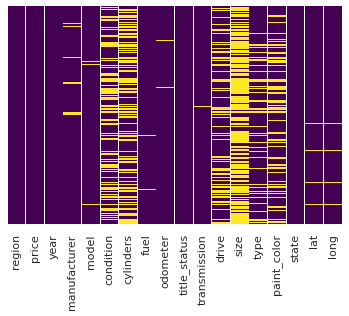

In [7]:
# recap of missing value heat map
sns.heatmap(df.isnull(), 
            yticklabels=False,
            cbar=False, 
            cmap='viridis');

In [8]:
# calculate percentage of missing values per column
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing,
                                 'missing_values': df.isnull().sum()}
                                )
missing_value_df.sort_values(['percent_missing'], ascending=False).transpose()

,size,cylinders,condition,drive,paint_color,type,manufacturer,title_status,lat,long,model,odometer,fuel,transmission,year,price,state,region
column_name,size,cylinders,condition,drive,paint_color,type,manufacturer,title_status,lat,long,model,odometer,fuel,transmission,year,price,state,region
percent_missing,71.7675,41.6225,40.7852,30.5863,30.5011,21.7527,4.13371,1.93075,1.53415,1.53415,1.23618,1.03073,0.705819,0.598763,0.282281,0,0,0
missing_values,306361,177678,174104,130567,130203,92858,17646,8242,6549,6549,5277,4400,3013,2556,1205,0,0,0


This dataset contains a lot of missing values, in one feature it even exceeds a quota of 70%!

This confronts us with a dilemma: We either sacrifice a large portion of our data to maintain a complete dataset or we heavily impute/interpolate our dataset to 'fill in the blanks'. The latter option is especially risky when there are a lot of missing values in one column.

The goal should be to strike a balance between both options.

In the previous task we established that the data does seem to be missing at random, excluding VIN, which has been removed anyway. We could statistically check for values completly at random with Little's MCAR test, but as with the datetime conversion, it wouldn't be feasible to do with this large dataset, Also, the MCAR test works best with numerical data, since it's calculated with mean values. Since the majority of missing values are in the categorical features, the MCAR-test probably wouldn't perform very well.

In short, since we didn't implement any MCAR test, we'll proceed with the assumption that values are MCAR (missing completly at random).

## Removing and Imputing missing values

As mentioned above, we need to strike a balance between removing and imputing values. It's not benificial for example to impute features that are missing in a large portion of the data, as the imputed values can heavily skew this feature. At the same time we want to retain as large of a dataset as possible to have a large enough set to run our training.

Since we have a very large dataset with MCAR values, removing a large portion of our dataset would still leave us with a large enough dataset to work with.
Another alternative would be to simply remove the features with a lot of missing values, like 'size', or 'cylinders' for example. These features could pose as important for our modeling later on though, which is the reason why we wouldn't want to remove them.

### The plan
1. Rows with missing values in features with > 5% will be removed
2. The remaining data of the features with < 5% of missing values will be imputed

Reference will be the row count of the data when indiscriminately removing every missing value

In [14]:
# row count after dropping every missing value
df_no_mv = df.dropna()
df_no_mv.shape[0]

79016

### Removing MVs (> 5%)

In [15]:
df_impute = df.dropna(subset=['size', 'cylinders', 'condition', 'drive', 'paint_color', 'type'])
df_impute.shape[0]

84651

We gained about 5000 entries by only removing features with a significant amount of missing values. Still, less than a quarter of the previous data remains. Since the difference between deleting all missing values and only removing a portion didn't result in a drastic difference in rows, we could also continue with the completly cleansed dataset, as we wouldn't have to worry about the impact imputation could have on the modeling.

For now, we'll consider both datasets with and without imputation.

In [20]:
# calculate percentage of missing values per column
percent_missing = df_impute.isnull().sum() * 100 / len(df_impute)
missing_value_df = pd.DataFrame({'column_name': df_impute.columns,
                                 'percent_missing': percent_missing,
                                 'missing_values': df_impute.isnull().sum()}
                                )
missing_value_df.sort_values(['percent_missing'], ascending=False).transpose()

,manufacturer,model,odometer,long,lat,transmission,drive,state,paint_color,type,size,region,price,fuel,cylinders,condition,year,title_status
column_name,manufacturer,model,odometer,long,lat,transmission,drive,state,paint_color,type,size,region,price,fuel,cylinders,condition,year,title_status
percent_missing,4.79853,1.15179,0.485523,0.229176,0.229176,0.0129945,0,0,0,0,0,0,0,0,0,0,0,0
missing_values,4062,975,411,194,194,11,0,0,0,0,0,0,0,0,0,0,0,0


Almost 5% of the dataset has a missing manufacturer. That's every 20th datapoint that is missing this information. Imputing the manufacturer is troublesome since there is a large set to choose from. Imputing the most frequent manufacturer would most certainly result in a mismatch. Same goes for model, which has a much lower percentage of MVs though.

This problem could partially be solved by using a fuzzy matching approach on manufacturer and model.
Since many adverts have their manufacturer written in the model column, we could scan this column for a match and apply the manufacturer for the respective match.

In [22]:
df_impute[df_impute['manufacturer'].isnull()]

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
122,auburn,6800,2005.0,NaN,blue bird bus,excellent,6 cylinders,diesel,180000.0,clean,automatic,rwd,full-size,bus,yellow,al,32.833700,-85.119700
137,auburn,2500,1966.0,NaN,1966 C-30 1 ton,good,6 cylinders,gas,47000.0,clean,manual,rwd,full-size,pickup,brown,al,32.416900,-85.709400
264,birmingham,2500,1987.0,NaN,1987 Saab 900 Turbo,fair,4 cylinders,gas,125000.0,clean,manual,fwd,mid-size,coupe,silver,al,33.293200,-86.768000
374,birmingham,9900,2016.0,NaN,scion ia,excellent,4 cylinders,gas,21000.0,clean,automatic,fwd,compact,sedan,blue,al,33.867300,-84.769900
401,birmingham,6800,2005.0,NaN,blue bird bus,excellent,6 cylinders,diesel,180000.0,clean,automatic,rwd,full-size,bus,yellow,al,33.247300,-84.835000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425650,wausau,5950,2011.0,NaN,2.0 liter turbo,good,4 cylinders,gas,154400.0,clean,automatic,fwd,mid-size,sedan,black,wi,44.825600,-89.377700
425730,wausau,11899,1991.0,NaN,Chev. Camaro Rs,excellent,8 cylinders,gas,42000.0,clean,automatic,rwd,mid-size,coupe,green,wi,44.655645,-90.151709
426127,wausau,5400,1995.0,NaN,oldsmobile cutlass supreme,good,6 cylinders,gas,82000.0,clean,automatic,fwd,mid-size,convertible,white,wi,44.375800,-89.806200
426550,wyoming,14000,2013.0,NaN,2013 scion fr-s,excellent,4 cylinders,gas,63000.0,clean,manual,rwd,compact,coupe,silver,wy,41.312281,-105.575259


In retrospect fuzzy matching wouldn't result in a significant gain of data and thus not worth the effort. At a closer look it becomes apparent that the model column is used by many advertisers to note car manufacturers that aren't in the set of car manufactureres to choose from (e.g. Isuzu, Blue Bird, etc...)
The safest way to handle the manufacturer would be to remove them as well.
Since we face the same problem with model, we are going to remove them as well.

In [25]:
df_impute = df_impute.dropna(subset=['manufacturer', 'model'])
df_impute.shape[0]

79614

By removing MVs both in 'manufacturer' and 'model' have a mere 600 row gain over the naive approach of removing every MV. Speaking from intuition these 600 entries probably woulnd't make a significant difference in the model, but for the sake of the use case we'll still impute the remaining data. 

### Imputing MVs (< 5%)

In [26]:
# calculate percentage of missing values per column
percent_missing = df_impute.isnull().sum() * 100 / len(df_impute)
missing_value_df = pd.DataFrame({'column_name': df_impute.columns,
                                 'percent_missing': percent_missing,
                                 'missing_values': df_impute.isnull().sum()}
                                )
missing_value_df.sort_values(['percent_missing'], ascending=False).transpose()

,odometer,long,lat,transmission,state,paint_color,type,size,drive,region,price,fuel,cylinders,condition,model,manufacturer,year,title_status
column_name,odometer,long,lat,transmission,state,paint_color,type,size,drive,region,price,fuel,cylinders,condition,model,manufacturer,year,title_status
percent_missing,0.512473,0.224835,0.224835,0.0138167,0,0,0,0,0,0,0,0,0,0,0,0,0,0
missing_values,408,179,179,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Use of SimpleImputer:
  - **transmission**: most frequent value --> data very biased towards 'automatic'
  - ~**fuel**: most frequent value --> data very biased towards 'gas'~
  - ~**title_status**: most frequent value --> data very biased towards 'clean'~
  - **longitude**: take median --> median not far away from mean with the guarantee that it's a populated area
  - **latitude**: take median --> median not far away from mean with the guarantee that it's a populated area

In [16]:
# use of SimpleImputer:

(84651, 18)

Use of IterativeImputer:
- **odometer**: numerical values that could relate to other features (e.g. age of car, price, condition, etc...) 

# Distribution of Data and its Skewness

As is seen over 90% of the data has been removed, but for this data exploration task we'll prioritize data cleanliness over data quantity.

By doing correlation matrices, we can figure out features that aren't needed for some analytical tasks like linear regression

#Correlation between Features

To make out correlation between features we first need to convert categorical features into numerical ones. One way to do this is by one-hot encoding all categorical values

# Pairplot
https://colab.research.google.com/github/kirenz/modern-statistics/blob/main/10a-application-model-exploration.ipynb#scrollTo=cachNh6HBCvh